# UK Lotto Results Analysis

Author: Matthew Carter

## Introduction

The UK Lotto has been run by The National Lottery since 1994 and is now drawn twice a week. Players choose six balls and aim to match the six main balls in the draw to win the jackpot. Including a bonus ball, seven balls in total are drawn. Smaller prizes are won from matching two or more main balls.

In this mini analysis I look at the draws since the new Lotto format was introduced on the 8th October 2015 which increased the number of balls in the draw from 49 to 59.

## Importing the dataset

Lotto results for this project have been collected using my __[uk_lotto_scraper.py](https://github.com/MatthewCarterIO/uk-lotto-DA/blob/master/uk_lotto_scraper.py)__ file.

In [1]:
# Common Python packages that will be used throughout project.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from datetime import datetime
from collections import Counter
from itertools import combinations

In [2]:
# Import the draw results and convert the draw_date column into datetime objects (type not preserved in the CSV file).
results_df = pd.read_csv("lotto_results.csv", parse_dates=["draw_date"])
results_df.head()

,draw_date,main_balls,bonus_ball
0,2015-12-30,"[22, 31, 47, 52, 55, 59]",23
1,2015-12-26,"[17, 21, 31, 38, 44, 58]",20
2,2015-12-23,"[1, 2, 4, 19, 28, 41]",32
3,2015-12-19,"[13, 14, 27, 46, 48, 50]",42
4,2015-12-16,"[10, 12, 35, 46, 48, 57]",14


In [3]:
# Confirm the data types of each column and ensure there are no missing values.
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546 entries, 0 to 545
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   draw_date   546 non-null    datetime64[ns]
 1   main_balls  546 non-null    object        
 2   bonus_ball  546 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 12.9+ KB


The draw_date column has successfully been converted into datetime data types. The bonus_ball column are integers as desired, however saving the DataFrame to a CSV file in __[uk_lotto_scraper.py](https://github.com/MatthewCarterIO/uk-lotto-DA/blob/master/uk_lotto_scraper.py)__ resulted in the main_balls column, which contained lists of integers for each draw, being stored as strings.

In [4]:
print(type(results_df.loc[0, "main_balls"]))

<class 'str'>


In [5]:
from ast import literal_eval

# Function converting string back into a list of integers.
def string_to_int_list(string_list):
    return literal_eval(string_list)

# Apply function to each row of the main_balls column.
results_df["main_balls"] = results_df["main_balls"].apply(string_to_int_list)
print(type(results_df.loc[0, "main_balls"]))

<class 'list'>


In this analysis the draw dates of interest are those after the 8th October 2015 when the new Lotto format was introduced, running to the present (25th March 2020 at time of writing).

In [6]:
# Sort the DataFrame into ascending date order and set the draw_date column as the index.
results_df.sort_values(by=["draw_date"], inplace=True)
results_df.set_index("draw_date", inplace=True)
results_df.head()

,main_balls,bonus_ball
draw_date,,
2015-01-03,"[10, 15, 17, 18, 19, 31]",24
2015-01-07,"[4, 5, 10, 12, 20, 23]",24
2015-01-10,"[13, 14, 16, 24, 41, 43]",39
2015-01-14,"[17, 20, 28, 29, 33, 36]",23
2015-01-17,"[29, 37, 42, 46, 47, 49]",4


In [7]:
# Select rows in DataFrame between 8th October 2015 and 25th March 2020 by taking a slice of the original 
# DataFrame.
results_df = results_df["2015-10-08" : "2020-03-25"]
results_df

,main_balls,bonus_ball
draw_date,,
2015-10-10,"[2, 3, 16, 32, 53, 54]",8
2015-10-14,"[7, 13, 20, 27, 39, 52]",35
2015-10-17,"[8, 30, 37, 40, 46, 50]",36
2015-10-21,"[13, 14, 21, 25, 51, 53]",39
2015-10-24,"[29, 31, 43, 55, 58, 59]",11
...,...,...
2020-03-11,"[10, 39, 45, 46, 52, 54]",12
2020-03-14,"[7, 22, 30, 38, 42, 47]",14
2020-03-18,"[3, 7, 11, 19, 27, 52]",5


For analysis it will be useful to have each of the six main balls in its own column.

In [8]:
# Create a new DataFrame containing just the main balls.
main_balls_df = pd.DataFrame(results_df["main_balls"].tolist(), index=results_df.index)
# Rename the columns.
main_balls_df.columns = [("ball_" + str(x)) for x in range(1, 7)]
# Combine this new DataFrame with the results DataFrame.
results_df = pd.concat([results_df, main_balls_df], axis=1)
results_df.head()

,main_balls,bonus_ball,ball_1,ball_2,ball_3,ball_4,ball_5,ball_6
draw_date,,,,,,,,
2015-10-10,"[2, 3, 16, 32, 53, 54]",8,2,3,16,32,53,54
2015-10-14,"[7, 13, 20, 27, 39, 52]",35,7,13,20,27,39,52
2015-10-17,"[8, 30, 37, 40, 46, 50]",36,8,30,37,40,46,50
2015-10-21,"[13, 14, 21, 25, 51, 53]",39,13,14,21,25,51,53
2015-10-24,"[29, 31, 43, 55, 58, 59]",11,29,31,43,55,58,59


Logically the bonus ball column should come after the main balls in the DataFrame.

In [9]:
# Save the bonus ball column as a Series.
bonus_ball_series = results_df["bonus_ball"]
# Remove the bonus ball column from the DataFrame
results_df = results_df.drop(["bonus_ball"], axis=1)
# Add the bonus ball column once again at the end of the DataFrame.
results_df = pd.concat([results_df, bonus_ball_series], axis=1)
results_df.head()

,main_balls,ball_1,ball_2,ball_3,ball_4,ball_5,ball_6,bonus_ball
draw_date,,,,,,,,
2015-10-10,"[2, 3, 16, 32, 53, 54]",2,3,16,32,53,54,8
2015-10-14,"[7, 13, 20, 27, 39, 52]",7,13,20,27,39,52,35
2015-10-17,"[8, 30, 37, 40, 46, 50]",8,30,37,40,46,50,36
2015-10-21,"[13, 14, 21, 25, 51, 53]",13,14,21,25,51,53,39
2015-10-24,"[29, 31, 43, 55, 58, 59]",29,31,43,55,58,59,11


In [10]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 466 entries, 2015-10-10 to 2020-03-25
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   main_balls  466 non-null    object
 1   ball_1      466 non-null    int64 
 2   ball_2      466 non-null    int64 
 3   ball_3      466 non-null    int64 
 4   ball_4      466 non-null    int64 
 5   ball_5      466 non-null    int64 
 6   ball_6      466 non-null    int64 
 7   bonus_ball  466 non-null    int64 
dtypes: int64(7), object(1)
memory usage: 32.8+ KB


The data is now filtered for the draws of interest and organised, ready for analysis.

## Analysis

### Initial overview

Lotto numbers are a categorical (nominal) data type since their numbers are only identifiers (could easily be replaced with words or colours etc.).

In the 466 draws that took place in this dataset, I'd expect the number of times each ball was drawn to be fairly similar.

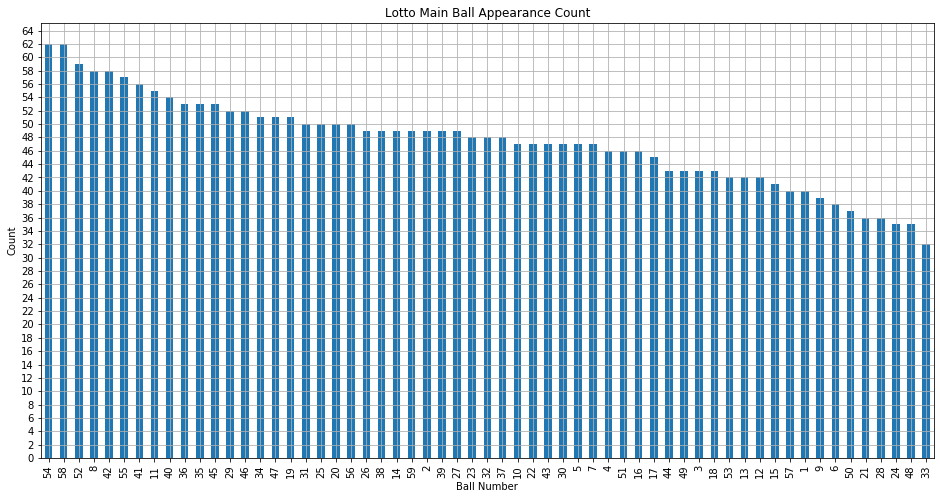

In [11]:
# Display a bar plot showing the number of times each ball has been drawn.
main_ball_count = results_df[["ball_1", "ball_2", "ball_3", "ball_4", "ball_5", "ball_6"]].stack().value_counts()
main_ball_count.plot(kind="bar", figsize=(16,8), title="Lotto Main Ball Appearance Count", grid=True, yticks=range(0, 66, 2))
plt.xlabel("Ball Number")
plt.ylabel("Count")
plt.show()

The bar chart above shows the number of times each ball has appeared in descending order from left to right. The most popular numbers was drawn 62 times and the least popular just 32 times.

In [12]:
main_ball_count.describe()

count    59.000000
mean     47.389831
std       6.789995
min      32.000000
25%      43.000000
50%      48.000000
75%      51.000000
max      62.000000
dtype: float64

The average appearance count of the balls was 47.4 (and with a median of 48 outliers are not an issue). The interquartile range was a fairly narrow 8, with 50% of the balls appearing between 43 and 51 times. However the range between least and most appearances is substantial at 30. This can be visualised with a box plot.

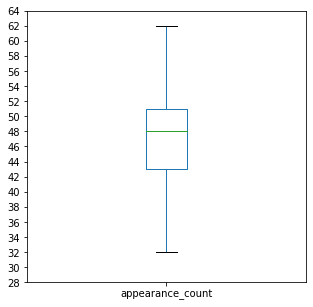

In [13]:
# Display a box plot for the count data. 
# NB. Although a boxplot can be created from a Series, to use the name in the plot it needs converting a into DataFrame.
main_ball_count_df = main_ball_count.to_frame(name="appearance_count")
main_ball_count_df.plot(kind="box", figsize=(5,5), yticks=range(28, 66, 2))
plt.show()

### Top six

If the top six drawn numbers from all 466 draws in this dataset had been played each time, how many times would a prize have been won?

In [14]:
# Function to compare two ordered lists of unique numbers and return the number of matches.
def ticket_checker(draw_list, ticket_list):
    # Check if lists are of equal length.
    if len(draw_list) != len(ticket_list):
        # Lists unequal length, exit function.
        print("Lists unequal length.")
        return
    # Check each list contains only unique values.
    if (len(draw_list) != len(set(draw_list))) or (len(ticket_list) != len(set(ticket_list))):
        # At least one of the lists contains duplicate numbers, exit function.
        print("Lists contain duplicate numbers.")
        return
    # Ensure both lists are in ascending order. 
    draw_list.sort()
    ticket_list.sort()
    # Check for matches.
    no_of_matches = 0
    index_draw = 0 
    index_ticket = 0
    while (index_ticket <= (len(ticket_list)-1)) and (index_draw <= (len(draw_list)-1)):
            if ticket_list[index_ticket] == draw_list[index_draw]:
                # Numbers match, move onto next ball on ticket and in draw.
                no_of_matches += 1
                index_ticket += 1
                index_draw += 1
            elif ticket_list[index_ticket] > draw_list[index_draw]:
                # Ticket ball is higher than the drawn ball it is being compared to. Move onto next ball from draw.
                index_draw += 1
            else:
                # Ticket ball is lower than the drawn ball it is being compared to. Move onto next ball on ticket.
                index_ticket += 1
    return no_of_matches

In [15]:
# Top six numbers from 466 draws in this dataset. 
top_six_numbers = [8, 42, 52, 54, 55, 58]
wins_series = results_df["main_balls"].apply(lambda x: ticket_checker(x, top_six_numbers))
wins_series.value_counts()

0    200
1    187
2     69
3      9
4      1
Name: main_balls, dtype: int64

In [16]:
# Highlight the draws where the ticket matched three or four balls.
matches = (wins_series == 3) | (wins_series == 4)
wins_series[matches]

draw_date
2016-01-27    3
2017-03-25    3
2017-10-28    4
2017-12-30    3
2018-07-04    3
2018-09-15    3
2019-06-15    3
2020-01-15    3
2020-02-08    3
2020-02-29    3
Name: main_balls, dtype: int64

Prizes are given for matching two or more balls, so for the six most popular numbers, 79 tickets would have been winners. With each ticket costing £2, the outlay would have been £932. Two balls give you a free lucky dip ticket which for the moment I am assuming is a loss, so the only concrete return on the investment would have been £270 for the tickets matching three balls (each win £30) and £140 for the draw matching four balls. This gives a current total return of £410.

### Lucky dip

Above I made the assumption that a lucky dip ticket would always give zero return which is clearly not the reality. After all, despite not being picked by a human they are still just six random numbers. So to provide a more accurate total return, how much might a lucky dip ticket make across the same 466 draws?

In [17]:
# Function to create lucky dip (random) lottery tickets.
def create_lucky_dip_tickets(no_of_tickets, ball_no_list):
    ticket_wallet = []
    for i in range(no_of_tickets):
        # Set the seed for reproducability purposes of this project.
        random.seed(i)
        # Create a random six number ticket from all ball numbers in list, sorted in ascending order.
        ticket = sorted(random.sample(ball_no_list, 6))
        ticket_wallet.append(ticket)
    # Return list of tickets.
    return ticket_wallet

In [18]:
# Create a list of balls 1-59.
ball_numbers = range(1,60)
# Create 100 lucky dip tickets.
my_lucky_dip_tickets = create_lucky_dip_tickets(100, ball_numbers)
my_lucky_dip_tickets

[[3, 17, 25, 27, 49, 55],
 [5, 9, 37, 49, 52, 55],
 [4, 6, 24, 55, 56, 59],
 [9, 16, 24, 35, 38, 39],
 [7, 16, 20, 26, 31, 47],
 [17, 23, 40, 45, 48, 51],
 [6, 32, 37, 49, 51, 53],
 [4, 5, 10, 21, 26, 42],
 [9, 13, 15, 24, 25, 46],
 [9, 12, 18, 24, 30, 40],
 [1, 3, 28, 31, 37, 59],
 [29, 30, 36, 50, 55, 56],
 [18, 23, 31, 34, 43, 57],
 [12, 17, 19, 44, 52, 57],
 [7, 34, 40, 42, 45, 49],
 [1, 3, 11, 14, 34, 48],
 [15, 19, 24, 27, 31, 58],
 [19, 20, 24, 27, 34, 52],
 [8, 12, 16, 22, 29, 43],
 [3, 8, 33, 34, 44, 51],
 [10, 44, 47, 50, 51, 58],
 [11, 19, 27, 41, 45, 58],
 [2, 9, 16, 29, 40, 59],
 [2, 6, 19, 38, 50, 54],
 [12, 14, 25, 38, 46, 54],
 [1, 14, 25, 50, 54, 57],
 [13, 14, 28, 39, 43, 48],
 [13, 18, 19, 31, 42, 45],
 [8, 9, 35, 39, 46, 48],
 [5, 23, 36, 39, 55, 56],
 [2, 19, 35, 40, 52, 56],
 [1, 8, 10, 26, 31, 49],
 [5, 10, 14, 16, 20, 45],
 [11, 15, 37, 41, 53, 54],
 [2, 15, 23, 34, 38, 54],
 [9, 22, 36, 48, 49, 58],
 [2, 4, 19, 22, 51, 52],
 [6, 39, 40, 43, 44, 54],
 [7, 27, 28

In [19]:
# Function to check each lucky dip ticket in a list against all the draws in the results_df DataFrame.
def check_lucky_dip_tickets(list_of_tickets):
    # Create a dictionary to hold the results and a counter to name the keys.
    lucky_dip_results = {}
    ticket_no = 1
    for ticket in list_of_tickets:
        # Use the ticket_checker() function to check the current ticket against all draws in DataFrame.
        lucky_dip_series = results_df["main_balls"].apply(lambda x: ticket_checker(x, ticket))
        # Add the results to the dictionary.
        lucky_dip_results[("ticket_" + str(ticket_no))] = [ticket, lucky_dip_series.value_counts()]
        ticket_no += 1
    return lucky_dip_results

In [20]:
# Check how the lucky dip tickets would have fared in the 466 draws.
hundred_results_dict = check_lucky_dip_tickets(my_lucky_dip_tickets)
hundred_results_dict

{'ticket_1': [[3, 17, 25, 27, 49, 55],
  0    237
  1    178
  2     44
  3      7
  Name: main_balls, dtype: int64],
 'ticket_2': [[5, 9, 37, 49, 52, 55],
  0    226
  1    192
  2     43
  3      5
  Name: main_balls, dtype: int64],
 'ticket_3': [[4, 6, 24, 55, 56, 59],
  0    245
  1    172
  2     44
  3      5
  Name: main_balls, dtype: int64],
 'ticket_4': [[9, 16, 24, 35, 38, 39],
  0    249
  1    170
  2     40
  3      7
  Name: main_balls, dtype: int64],
 'ticket_5': [[7, 16, 20, 26, 31, 47],
  0    239
  1    169
  2     50
  3      8
  Name: main_balls, dtype: int64],
 'ticket_6': [[17, 23, 40, 45, 48, 51],
  0    231
  1    190
  2     44
  3      1
  Name: main_balls, dtype: int64],
 'ticket_7': [[6, 32, 37, 49, 51, 53],
  0    249
  1    177
  2     32
  3      8
  Name: main_balls, dtype: int64],
 'ticket_8': [[4, 5, 10, 21, 26, 42],
  0    237
  1    183
  2     38
  3      8
  Name: main_balls, dtype: int64],
 'ticket_9': [[9, 13, 15, 24, 25, 46],
  0    257
  1    1

Although some lucky dip tickets matched four balls, to be conservative I will just focus on the number of times any winning tickets matched three balls and use an average value to adjust the total return calculated earlier. 

In [21]:
# For each ticket, access the value count in the dictionary corresponding to three matches.
three_matches_count = []
for ticket in hundred_results_dict:
    # Check if the ticket has any three-ball matches using the lucky_dip_series.value_counts() value in the 
    # dictionary (hundred_results_dict[ticket][1]).
    if 3 in hundred_results_dict[ticket][1].index:
        three_matches_count.append(hundred_results_dict[ticket][1][3])
    else:
        three_matches_count.append(0)

# Calculate the average by summing the list and dividing by the number of elements.
print(f"Average three balls matched: {sum(three_matches_count) / len(three_matches_count)}")

Average three balls matched: 5.43


Based on one hundred lucky dip tickets, three balls might be matched 5.43 times in 466 draws giving a win ratio of approximately 1:86. Given this ratio and the fact that the top six numbers played earlier only provided 69 free lucky dip tickets, the previous assumption that they would give no monetary return is fair in this basic analysis.

### Time elapsed

Players might like to know how much time has passed since a ball has been drawn when picking their numbers.

In [22]:
# Function to get all the dates that a ball appeared in a draw.
def get_ball_draw_dates(ball_no):
    # Create boolean mask Series from the dataframe showing True for a row if the ball number has appeared in any 
    # of the main ball columns.
    ball_appeared_mask = results_df[["ball_1","ball_2","ball_3","ball_4","ball_5","ball_6"]].isin([ball_no]).any(axis="columns")
    # For each True row in the mask, retreive its index value (i.e. the draw date) and store it in a list.
    ball_drawn_dates = []
    for index, bool_value in ball_appeared_mask.items():
        if bool_value:
            ball_drawn_dates.append(index)
    return ball_drawn_dates

In [23]:
# Function to get time between ball last being drawn and the present (taken to be the last draw in dataset, 
# 25th March 2020).
def get_days_last_appeared(ball_no):
    # Get all dates that the ball was drawn.
    drawn_dates = get_ball_draw_dates(ball_no)
    # As it is an already ordered list the most recent date the ball appeared is last, so subract it from the
    # "present" date.
    return (datetime(2020, 3, 25) - drawn_dates[-1]).days

Now to find the ten balls that haven't appeared for the longest time.

In [24]:
# Get the number of days since each of the 59 balls was last drawn.
last_appeared = {}
for ball in range(1, 60):
    # Store ball number with days since last appearance in a dictionary.
    last_appeared[ball] = get_days_last_appeared(ball)

# Create a list that is sorted in descending order using the values of the dictionary.
last_appeared_sorted = sorted(last_appeared.items(), key=lambda x: x[1], reverse=True)
# Get the top ten elements from the list.
last_appeared_sorted[:10]

[(37, 175),
 (17, 126),
 (9, 112),
 (6, 109),
 (16, 105),
 (1, 88),
 (13, 81),
 (15, 70),
 (31, 49),
 (8, 46)]

Five balls haven't appeared in a Lotto draw for over 100 days, with 37 being a long way in front having not appeared for 175 days.

To find out how typical these time periods are, it would help to find the maximum time that elapsed between draws where the same ball appeared.

In [25]:
# Function to get minimum and maximum number of days between the same ball being drawn.
def get_min_max_days_between(ball_draw_dates_list):
    max_days_between = 0
    min_days_between = 0
    for i in range(0, len(ball_draw_dates_list)-1):
        days_between = (ball_draw_dates_list[i+1] - ball_draw_dates_list[i]).days
        if days_between > max_days_between:
            max_days_between = days_between
        if (days_between < min_days_between) | (min_days_between == 0):
            min_days_between = days_between
    return (min_days_between, max_days_between)

In [26]:
# Get the minimum and maximum number of days elapsed between a ball being drawn for all 59 balls. 
days_elapsed = {}
for ball in range(1, 60):
    # Store ball number with min and max time elapsed between appearances in a dictionary.
    days_elapsed[ball] = get_min_max_days_between(get_ball_draw_dates(ball))
days_elapsed

{1: (3, 136),
 2: (3, 200),
 3: (3, 147),
 4: (3, 140),
 5: (3, 175),
 6: (3, 144),
 7: (3, 164),
 8: (3, 122),
 9: (4, 186),
 10: (3, 130),
 11: (3, 109),
 12: (3, 126),
 13: (3, 137),
 14: (3, 136),
 15: (3, 154),
 16: (3, 140),
 17: (3, 182),
 18: (3, 122),
 19: (3, 137),
 20: (3, 126),
 21: (3, 392),
 22: (4, 140),
 23: (3, 224),
 24: (3, 228),
 25: (3, 122),
 26: (3, 147),
 27: (3, 161),
 28: (3, 161),
 29: (3, 168),
 30: (3, 105),
 31: (3, 122),
 32: (3, 102),
 33: (10, 238),
 34: (3, 154),
 35: (3, 154),
 36: (3, 105),
 37: (3, 161),
 38: (3, 94),
 39: (3, 98),
 40: (3, 130),
 41: (3, 119),
 42: (3, 101),
 43: (3, 133),
 44: (3, 105),
 45: (3, 108),
 46: (3, 126),
 47: (3, 112),
 48: (3, 175),
 49: (3, 115),
 50: (3, 165),
 51: (4, 119),
 52: (3, 112),
 53: (3, 154),
 54: (3, 168),
 55: (3, 112),
 56: (3, 147),
 57: (4, 224),
 58: (3, 115),
 59: (3, 217)}

The overall minimum and maximum days elapsed between ball appearances can be found from this dictionary.

In [27]:
# Create a list containing just the minimum number of days between each ball appearing from the dictionary values and find
# the minimum value.
min_days_elapsed = [x[0] for x in days_elapsed.values()]
print(f"Overall minimum days elapsed: {min(min_days_elapsed)}")

Overall minimum days elapsed: 3


In [28]:
# Create a list containing just the maximum number of days between each ball appearing from the dictionary values and find
# the maximum value.
max_days_elapsed = [x[1] for x in days_elapsed.values()]
print(f"Overall maximum days elapsed: {max(max_days_elapsed)}")

Overall maximum days elapsed: 392


In general, as the dictionary shows, the least time that a ball has taken to appear again is either three (Weds to Sat) or four (Sat to Weds) days. The longest time between appearances seems to be more varied and Numpy can be used to confirm this.

In [29]:
print(f"Unique minimum elapsed days: {len(np.unique(min_days_elapsed))}")
print(f"Unique maximum elapsed days: {len(np.unique(max_days_elapsed))}")

Unique minimum elapsed days: 3
Unique maximum elapsed days: 33


Therefore visualising the maximum time between each ball appearing will be more useful than doing it for the minimum elapsed times. This data is not normally distributed, so adding a median line (rather than a mean) to show whether a ball is in the upper or lower half of the `max_days_elapsed` list is a useful indicator.

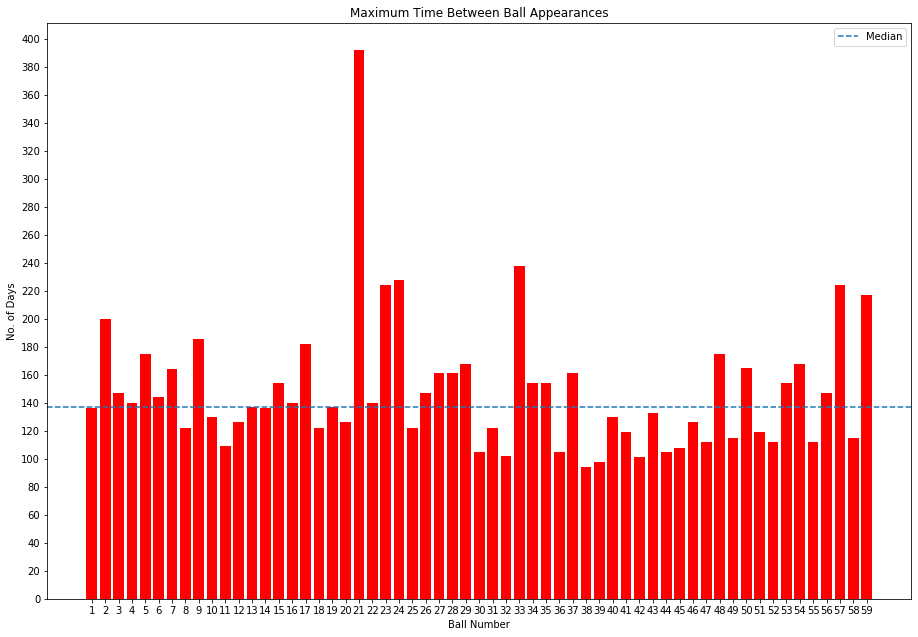

In [30]:
# Plot bar chart of maximum time elapsed between appearances for each ball.
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0,0,1,1])
ax.bar(days_elapsed.keys(), max_days_elapsed, color='r')
ax.axhline(y=np.median(max_days_elapsed), linestyle="--", label="Median")
ax.set_title("Maximum Time Between Ball Appearances")
ax.set_xlabel("Ball Number")
ax.set_ylabel("No. of Days")
ax.set_xticks(range(1,60))
ax.set_yticks(range(0,420,20))
ax.legend()
plt.show()

### Common pairs

How often do the same pair of balls appear in Lotto draws?

In [31]:
# Create a counter to store the pairs and how often they occur.
pairs_counter = Counter()
# For each row/draw in the main_balls column of the results_df, extract all possible pair combinations and add them
# to the counter.
for draw in results_df["main_balls"]:
    for combination in combinations(draw, 2):
        pairs_counter[combination] += 1
# Display the ten most common ball pairs from all draws in this dataset.
pairs_counter.most_common(10)

[((2, 54), 11),
 ((34, 52), 11),
 ((14, 19), 11),
 ((26, 35), 11),
 ((7, 47), 11),
 ((10, 54), 10),
 ((42, 58), 10),
 ((19, 29), 10),
 ((27, 36), 10),
 ((7, 58), 10)]